<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Bayesianos</div><br>
    <div style="font-size: x-large; color:gray">Practica: Mixtura de Gausianas</div><br>
    <div style="font-size: large; color:#FF0000">Francisco Javier Sáez Maldonado -  José Antonio Álvarez Ocete</div><br></div><hr>
</div>

In [2]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_{k=1}^K \pi_k = 1$ y donde $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componentes donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. 

<u>Paso E:</u>

En el **paso E**, estimaremos $D \times K$ valores de la siguiente forma:

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

**Editado por Dreji**: estimaremos $N \times K$ valores de la siguiente forma:

$$
q_i(z_k=1) = \frac{p(z_k=1)p(x_i|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(x_i|z_k=1)}
= \frac{\pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}{\sum_{k=1}^K \pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}
$$

<u>Paso M:</u>

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N \ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

**Editado por Dreji**:

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$
\begin{align*}
\mathbf{\mu}_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\pi_k} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
\end{align*}
$$

Como $q_i(z_k=1)$ es la columna $k-$ésima de la matriz $Q$ calculada en el paso E, basta con multiplicar la matriz $X$ (fila a fila) por la columna $k$ de la matriz $Q$ elemento a elemento y calcular la media. Finalmente, dividimos por el valor $\pi_k$ para obtener $\mu_k$.

$$
\begin{align*}
\Sigma_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\pi_k} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
\end{align*}
$$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N \ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

## Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos:
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen, se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5).
- El cálculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de $q$ antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego utilizar la función `np.logsumexp` para normalizar en el espacio de logprobs. 
- Finalmente, para evitar problemas numéricos al invertir la matriz de covarianza, se recomienda usar la descomposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad.

In [105]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib
import scipy 
import matplotlib as mpl

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal


%matplotlib inline
%load_ext autoreload
%autoreload 2

matplotlib.rcParams['figure.figsize'] = (10,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
import matplotlib.transforms as transforms

def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs
    )

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # Calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    ax.scatter(mean_x, mean_y, marker='x', c=color)

    return ax.add_patch(ellipse)

In [326]:
# Generar datos
def generate_dataset(rotate=True, K=3, random_state=12345):
    X, y = make_blobs(100, centers=K, random_state=random_state)
    transformation = np.identity(2)
    if rotate:
        np.random.seed(random_state)
        transformation = np.array([[ (0.2+np.random.rand())*2,  0.5-np.random.rand()], 
                                       [0.5-np.random.rand(), (0.2+np.random.rand())*2]])
        for y_k in np.unique(y):
            X[y==y_k, :] = np.dot(X[y==y_k, :], transformation)

    return X, y, transformation

def plot_elipses(X, y, transformation):
    fig = plt.figure()
    for y_k in np.unique(y):
        plt.scatter(X[y==y_k, 0], X[y==y_k, 1], label=y_k)
        make_ellipse(transformation, np.mean(X[y==y_k, :], axis=0),
                     ax=fig.axes[0], facecolor='none',
                     edgecolor='red')

    fig.axes[0].axis('equal')
    plt.legend()
    return fig

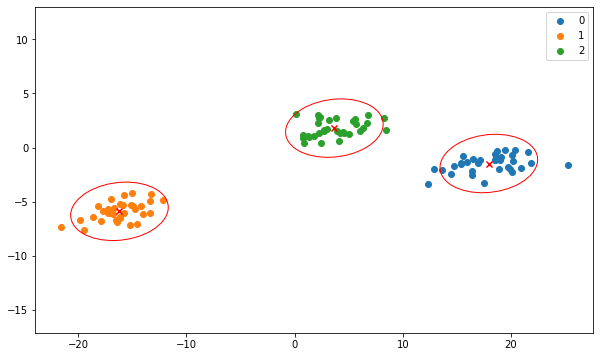

In [327]:
X, y, transformation = generate_dataset()
_ = plot_elipses(X, y , transformation)

<div class="qst">

* Completa la clase `GMM` satisfaciendo los requisitos indicados anteriormente.

</div>

In [378]:
class GMM:
    """ 
        Sugerencia para la organización del código
    """
    
    def __init__(self, K=3, n_iterations=100, random_state=1234, reg_value=1e-10):
        self.K = K
        self.n_iterations = n_iterations
        self._random_state = random_state
        self.log_likelihoods = []
        
        # Value added to the diagonal of the covariance matrices
        # to avoid singular matrix due to numerical errors.
        self._regularization_val = reg_value
        self._regularization_matrix = reg_value * np.identity(X.shape[1])
    
    def _initialize(self, X):
        # Apply k-means for a initial prediction of the clusters
        y_pred = KMeans(n_clusters=self.K, random_state=self._random_state).fit_predict(X)
        
        # Predict initial quantities using the obtained labels
        labels = np.unique(y_pred)
        pi_prior = np.array([ np.sum(y_pred == i) for i in labels ]) / len(y_pred)
        means = [ np.mean(X[y_pred == i], axis=0) for i in labels ]
        
        # Add a small quantity to the covariance matrices' diagonals
        # so they are not singular
        covs = [
            np.cov(X[y_pred == i].T) + self._regularization_matrix
            for i in labels
        ]
        
        return pi_prior, means, covs

    def _e_step(self, X, priors, means, covs):
        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        # Compute the numerator of the Q matrix
        # Add a small regularization value to avoid numerical errors
        Q = [
            [
                pi_k * mvn.pdf(x_i) + self._regularization_val
                for pi_k, mvn in zip(priors, distributions)
            ]
            for x_i in X
        ]

        # Normalize Q matrix, by dividing each row by the sum of its values.
        Q = Q / np.sum(Q, axis=1).reshape(-1, 1)
        return Q
    
    def _m_step(self, X, Q):
        # Estimate pi
        priors = np.mean(Q, axis=0)
        
        # Estimate means
        means = [
            np.mean(X * Q[:, k].reshape(-1, 1), axis=0) / pi_k
            for k, pi_k  in enumerate(priors)
        ]
        
        # Estimate covariances
        covs = [
            np.mean([
                Q[i, k] * (x_i - mean_k).T * (x_i - mean_k)
                for i, x_i in enumerate(X)
            ]) / pi_k
            + self._regularization_matrix
            for k, (pi_k, mean_k)  in enumerate(zip(priors, means))
        ]
            
        return priors, means, covs
        
    def _compute_log_likelihood(self, X, priors, means, covs):
        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        return np.sum([
            np.log(np.sum([
                pi_k * mvn.pdf(x_i)
                for pi_k, mvn in zip(priors, distributions)
            ]))
            for x_i in X
        ])
        
    def fit(self, X):
        # Parameter initialization
        priors, means, covs = self._initialize(X)
        
        # Initialize the log-likelihoog vector
        self.log_likelihoods = [
            self._compute_log_likelihood(X, priors, means, covs)
        ]
        
        for i in range(self.n_iterations):
#             print('--------- Iteration {}'.format(i))
#             print('priors: ', priors)
#             print('means: ', means)
#             print('covs: ', covs)
            
            # Step E
            Q = self._e_step(X, priors, means, covs)
            
            # Step M
            priors, means, covs = self._m_step(X, Q)
            
            # Compute and save log-likelihood
            self.log_likelihoods.append(
                self._compute_log_likelihood(X, priors, means, covs)
            )
        
        return priors, means, covs

In [379]:
gmm = GMM(reg_value=1e-7)
priors, means, covs = gmm.fit(X)

c:\users\jose\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


In [380]:
priors, means, covs

(array([0.33333333, 0.33333333, 0.33333333]),
 [array([ 1.98236891, -1.84983793]),
  array([ 1.98236891, -1.84983793]),
  array([ 1.98236891, -1.84983793])],
 [array([[106.23416341, 106.23416331],
         [106.23416331, 106.23416341]]),
  array([[106.23416341, 106.23416331],
         [106.23416331, 106.23416341]]),
  array([[106.23416341, 106.23416331],
         [106.23416331, 106.23416341]])])

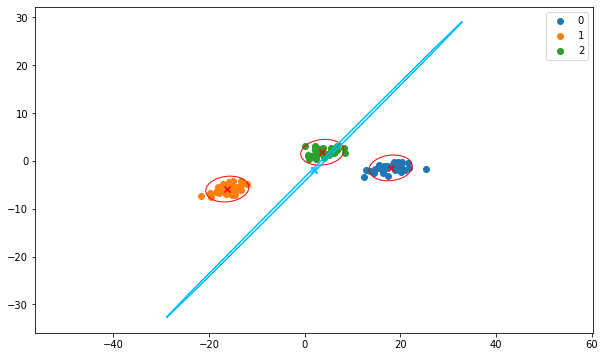

In [365]:
def plot_estimations(X, y, transformation, means, covs):
    fig = plot_elipses(X, y, transformation)
    
    for mean, cov in zip(means, covs):
        make_ellipse(cov, mean,ax=fig.axes[0], facecolor='none',
                     edgecolor='deepskyblue')

    fig.axes[0].axis('equal')
    _ = plt.legend()

plot_estimations(X, y, transformation, means, covs)

<div class="qst">

* Se deben **visualizar** los resultados obtenidos. Al menos se deben mostrar las covarianzas y medias finales estimadas (usando `make_ellipse`) y cómo ha evolucionado la log-verosimilitud de los datos.

</div>

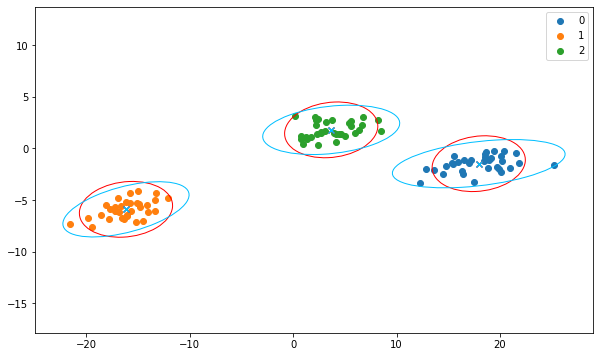

In [374]:
gmm = GMM(reg_value=1e-7)
priors, means, covs = gmm._initialize(X)
plot_estimations(X, y, transformation, means, covs)

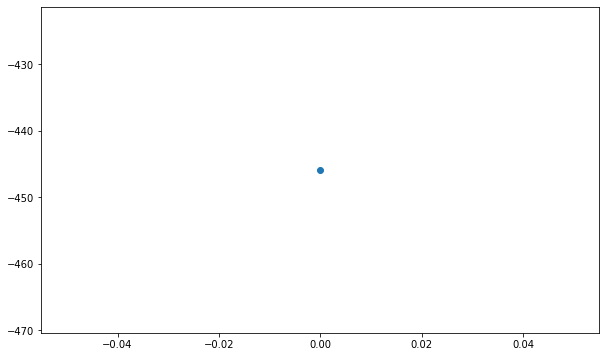

In [390]:
def plot_log_likelihood(gmm):
    plt.scatter(np.arange(gmm.n_iterations + 1), gmm.log_likelihoods)


plot_log_likelihood(gmm)

In [391]:
print(np.arange(gmm.n_iterations + 1))
gmm.log_likelihoods

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


[-445.86281802381086,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf]